In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import preprocessing, layers,models
tf.keras.backend.clear_session()
%load_ext tensorboard

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[data](https://zenodo.org/record/2538136#.YookYqhBy3A)
Label Map is given by:
* 0 : 'other'
* 1 : 'crater'
* 2 : 'dark dune'
* 3 : 'slope streak'
* 4 : 'bright dune'
* 5 : 'impact ejecta'
* 6 : 'swiss cheese'
* 7 : 'spider'

Dataset is very unbalanced :
* class : values
* 0  :  61054
* 1  :   4900
* 3  :   2331
* 4  :   1750
* 6  :   1148
* 2  :   1141
* 7  :    476
* 5  :    231

so, i balanced data and final dataset looks like below :
* class : values
* 0  :  1400
* 1  :  1400
* 3  :  1400
* 4  :  1400
* 6  :  1148
* 2  :  1141 (Remove class 7 and 5 and rename class 6 to 5.)

New Label Map is given by:

* 0 : 'other'
* 1 : 'crater'
* 2 : 'dark dune'
* 3 : 'slope streak'
* 4 : 'bright dune'
* 5 : 'swiss cheese'



### Load Dataset & info

In [5]:
BATCH_SIZE = 8
IMAGE_SIZE = 227

In [6]:
data_dir = '/content/drive/MyDrive/MARS_ORBITAL_DATA/DATA/balanced_data'

dataset = preprocessing.image_dataset_from_directory(
data_dir,
image_size= (227,227),
batch_size= BATCH_SIZE,
shuffle=True)

Found 7888 files belonging to 6 classes.


In [7]:
dataset.class_names

['0', '1', '2', '3', '4', '5']

In [8]:
map_label = {0 : 'other',
1 : 'crater',
2 : 'dark dune',
3 : 'slope streak',
4 : 'bright dune',
5 : 'swiss cheese'
}

### Plot some data and label

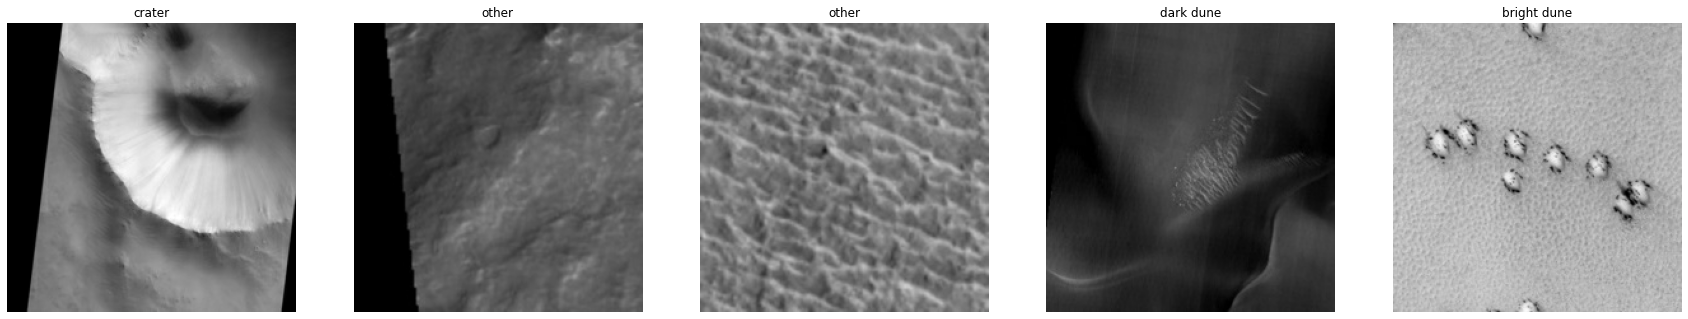

In [9]:
plt.figure(figsize=(30,10))
i=0
for imgs, labels in dataset.take(5):
  ax = plt.subplot(1, 5, i+1)
  plt.title(map_label[int(labels[0])])
  plt.imshow(imgs[0].numpy().astype('uint32'))
  plt.axis('off')
  i+=1
plt.show()
  

### Split data into train_validation_test split

In [10]:
def dataset_split(dataset, train_split=0.8,val_split=0.1, shuffle=True, shuffle_size=10000):
    size=len(dataset)
    if shuffle:
        dataset=dataset.shuffle(shuffle_size, seed=12)
    train_size=int(size*train_split)
    val_size=int(size*val_split)
    
    train_ds=dataset.take(train_size)
    val_ds= dataset.skip(train_size) 
    test_ds= val_ds.take(val_size)
    test_ds= val_ds.skip(val_size)

    return train_ds,val_ds,test_ds

In [11]:
train_ds,val_ds,test_ds = dataset_split(dataset)

In [10]:
print('train data' , len(train_ds), 'batches')
print('validation data' , len(val_ds), 'batches')
print('test data' , len(test_ds), 'batches')

train data 788 batches
validation data 198 batches
test data 100 batches


In [11]:
train_ds = train_ds.cache().shuffle(200).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(200).prefetch(buffer_size=tf.data.AUTOTUNE)

dataset has already augmented so no need to add augmentation layers.

In [12]:
rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
])

### Create resnet50_V2 as a base model

In [13]:
input = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE,3))

preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
resnet_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet')


##### Enable only last 5 layers to be trained.

In [14]:
for layer in resnet_model.layers[:-5]:
  layer.trainable = False

resnet_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 233, 233, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 114, 114, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

### Adding some top layers on base_model

In [15]:
global_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
dropout =  tf.keras.layers.Dropout(0.25)
dense2 = tf.keras.layers.Dense(60, activation = 'relu')
dense1 = tf.keras.layers.Dense(6, activation=None)

### Building Model

In [16]:
x = rescale(input)
x = preprocess_input(x)
x = resnet_model(x, training=False)
x = global_pooling_layer(x)
x = dropout(x)
x = dense2(x)
output = dense1(x)
model = tf.keras.Model(input, output)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 227, 227, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 227, 227, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 227, 227, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [18]:
model.compile(optimizer='SGD', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [19]:
def scheduler(epoch, lr):
   if epoch < 10:
     return lr
   else:
     return lr * 0.97

callback = [tf.keras.callbacks.LearningRateScheduler(scheduler)]

### Start Training

In [20]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks = callback, verbose=1)

Epoch 1/50
788/788 [==============================] - 79s 63ms/step - loss: 0.4021 - sparse_categorical_accuracy: 0.8542 - val_loss: 0.1954 - val_sparse_categorical_accuracy: 0.9299 - lr: 0.0100
Epoch 2/50
788/788 [==============================] - 32s 40ms/step - loss: 0.2055 - sparse_categorical_accuracy: 0.9266 - val_loss: 0.1849 - val_sparse_categorical_accuracy: 0.9331 - lr: 0.0100
Epoch 3/50
788/788 [==============================] - 32s 41ms/step - loss: 0.1608 - sparse_categorical_accuracy: 0.9429 - val_loss: 0.1269 - val_sparse_categorical_accuracy: 0.9552 - lr: 0.0100
Epoch 4/50
788/788 [==============================] - 32s 40ms/step - loss: 0.1305 - sparse_categorical_accuracy: 0.9529 - val_loss: 0.0989 - val_sparse_categorical_accuracy: 0.9640 - lr: 0.0100
Epoch 5/50
788/788 [==============================] - 32s 40ms/step - loss: 0.1085 - sparse_categorical_accuracy: 0.9615 - val_loss: 0.0910 - val_sparse_categorical_accuracy: 0.9665 - lr: 0.0100
Epoch 6/50
788/788 [=====

### Plot Training loss-accuracy history

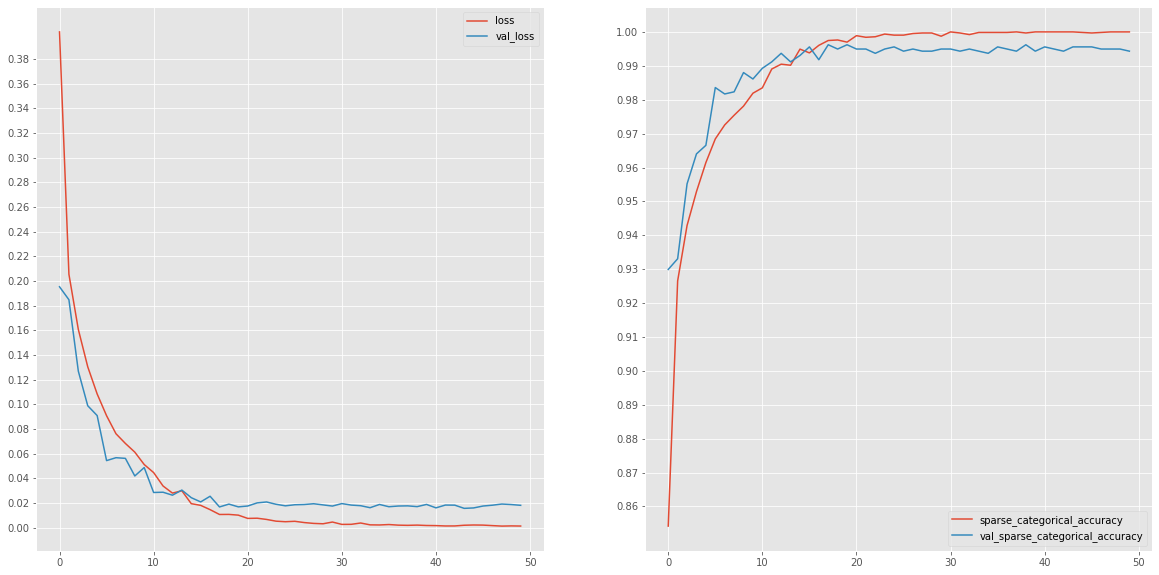

In [21]:
plt.figure(figsize=(20,10))
plt.style.use('ggplot')
ax = plt.subplot(1, 2, 1)
for key in ['loss', 'val_loss']:
  x = range(50)
  plt.plot(x, history.history[key], label=str(key))
  plt.yticks(ticks = np.arange(0,0.4,0.02))
plt.legend()

ax = plt.subplot(1, 2, 2)
for key in ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']:
  x = range(50)
  plt.plot(x, history.history[key], label=str(key))
  plt.yticks(ticks = np.arange(0.86,1,0.01))
plt.legend()

plt.savefig('/content/drive/MyDrive/MARS_ORBITAL_DATA/MODEL/final1.jpg', dpi=200)
plt.show()

### save trained model

In [22]:
import joblib
joblib.dump(model, '/content/drive/MyDrive/MARS_ORBITAL_DATA/MODEL/JOBLIB_PKL/final.pkl')

INFO:tensorflow:Assets written to: ram://29d3afe5-1bbf-473e-81e2-0777c1d875da/assets


['/content/drive/MyDrive/MARS_ORBITAL_DATA/MODEL/JOBLIB_PKL/final.pkl']

### prediction on test dataset

In [1]:
import joblib
model = joblib.load('/content/drive/MyDrive/MARS_ORBITAL_DATA/MODEL/JOBLIB_PKL/final.pkl')

In [12]:
import tensorflow_addons as tfa

test_ds = test_ds.unbatch().batch(800)
for imgs, lbls in test_ds.take(1):
  pred = model.predict(imgs)
  pred = np.argmax(pred, axis=1)
  pred = tf.keras.utils.to_categorical(pred, num_classes=6)
  lbls = tf.keras.utils.to_categorical(lbls, num_classes=6)
  metric = tfa.metrics.F1Score(num_classes=6, threshold=0.5)
  metric.update_state(lbls, pred)
  result = metric.result()

### F1 scores for all classes

In [13]:
for i, f1 in enumerate(np.asarray(result)):
  print(f'{map_label[i]}  :-  F1 score : {f1}')

other  :-  F1 score : 0.9800000190734863
crater  :-  F1 score : 0.9893993139266968
dark dune  :-  F1 score : 0.9956331253051758
slope streak  :-  F1 score : 0.9929577708244324
bright dune  :-  F1 score : 1.0
swiss cheese  :-  F1 score : 1.0


our model done wonderful job on each classes.

### Ploting Test data

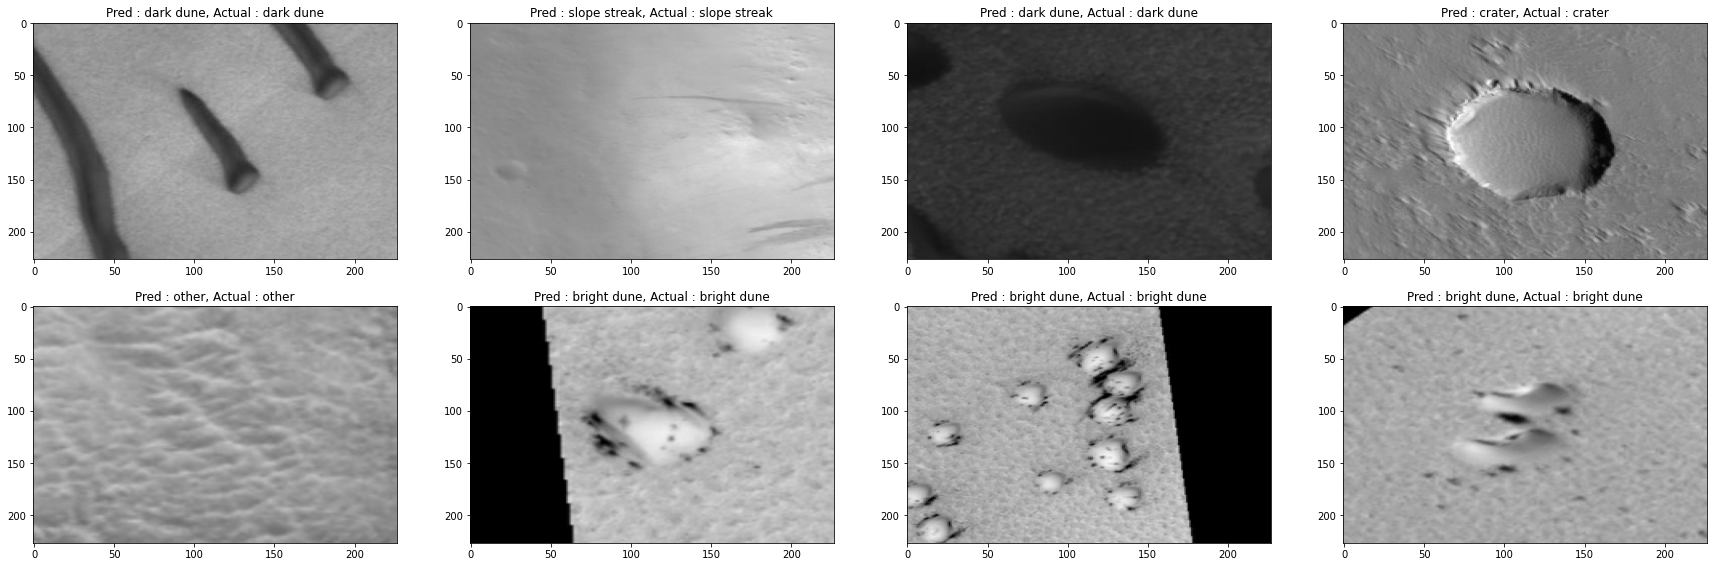

In [14]:
plt.figure(figsize=(30,20))
for imgs, labels in test_ds.take(1):
  pred = model.predict(imgs.numpy())
  pred = np.argmax(pred, axis=1)
  labels = np.asarray(labels)

  for i in range(8):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(imgs[i].numpy().astype('uint32'), aspect='auto')
    plt.title(f'Pred : {map_label[pred[i]]}, Actual : {map_label[labels[i]]}')
    plt.grid(False)
plt.show()